In [ ]:
import cv2
import os
from PIL import Image as Img
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import normalize, to_categorical,plot_model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,GaussianNoise,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix , classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
image_directory = 'drive/MyDrive/Colab Notebooks/Tumor_Efficientnet (1)/Tumor/Dataset'

In [ ]:
# Check if the directory exists
if os.path.exists(image_directory):
    # Load images from the 'no' subdirectory
    no_tumor_images = os.listdir(os.path.join(image_directory, 'no'))
    # Load images from the 'yes' subdirectory
    yes_tumor_images = os.listdir(os.path.join(image_directory, 'yes'))
else:
    print("Error: The specified directory does not exist.")

In [ ]:
INPUT_SIZE = 256

In [ ]:
def has_valid_extension(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

dataset=[]
label=[]

# Load and preprocess images from the 'no' class
for image_name in no_tumor_images:
    if has_valid_extension(image_name):
        image_path = os.path.join(image_directory, 'no', image_name)
        image = cv2.imread(image_path)
        if image is not None:  # Check if image is successfully loaded
            image = Img.fromarray(image, "RGB")
            image = image.resize((INPUT_SIZE, INPUT_SIZE))
            dataset.append(np.array(image))
            label.append(0)
        else:
            print(f"Failed to load image: {image_path}")

for image_name in yes_tumor_images:
    if has_valid_extension(image_name):
        image_path = os.path.join(image_directory, 'yes', image_name)
        image = cv2.imread(image_path)
        if image is not None:  # Check if image is successfully loaded
            image = Img.fromarray(image, "RGB")
            image = image.resize((INPUT_SIZE, INPUT_SIZE))
            dataset.append(np.array(image))
            label.append(1)
        else:
            print(f"Failed to load image: {image_path}")

In [ ]:
len(label)

3253

In [ ]:
dataset = np.array(dataset)
label = np.array(label)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

In [ ]:
x_train.shape

(2602, 256, 256, 3)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=16)
validation_generator = val_datagen.flow(x_test, y_test, batch_size=16)

In [ ]:
model = Sequential()

model.add(Conv2D(64,(3,3),input_shape = (INPUT_SIZE,INPUT_SIZE,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(128,(3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 activation_18 (Activation)  (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 activation_19 (Activation)  (None, 125, 125, 128)     0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 128)       0         
 ng2D)                                                

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [ ]:
lrp = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
filepath = 'drive/MyDrive/Colab Notebooks/Tumor_CNN (1)/Tumor_CNN.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint, lrp]

# Train model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.6733 - precision: 0.6568 - recall: 0.7638 - auc: 0.7261
Epoch 1: val_accuracy improved from -inf to 0.71736, saving model to drive/MyDrive/Colab Notebooks/Tumor_CNN (1)/Tumor_CNN.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 58s 343ms/step - loss: 0.6269 - accuracy: 0.6733 - precision: 0.6568 - recall: 0.7638 - auc: 0.7261 - val_loss: 0.5371 - val_accuracy: 0.7174 - val_precision: 0.6543 - val_recall: 0.8896 - val_auc: 0.8420 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.5510 - accuracy: 0.7244 - precision: 0.7235 - recall: 0.7511 - auc: 0.7965
Epoch 2: val_accuracy improved from 0.71736 to 0.74808, saving model to drive/MyDrive/Colab Notebooks/Tumor_CNN (1)/Tumor_CNN.h5
163/163 [==============================] - 65s 397ms/step - loss: 0.5510 - accuracy: 0.7244 - precision: 0.7235 - recall: 0.7511 - auc: 0.7965 - val_loss: 0.5208 - val_accuracy: 0.7481 - val_precision: 0.7270 - val_recall: 0.7729 - val_auc: 0.8176 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.7356 - precision: 0.7407 - recall: 0.7474 - auc: 0.8057
Epoch 3: val_accuracy improved from 0.74808 to 0.79263,

In [ ]:
model.evaluate(train_generator)

163/163 [==============================] - 39s 240ms/step - loss: 0.4137 - accuracy: 0.8144 - precision: 0.8571 - recall: 0.7668 - auc: 0.8986


[0.41374701261520386,
 0.8143735527992249,
 0.8571428656578064,
 0.7668161392211914,
 0.8986280560493469]

In [ ]:
model.evaluate(validation_generator)

41/41 [==============================] - 10s 236ms/step - loss: 0.3787 - accuracy: 0.8157 - precision: 0.8556 - recall: 0.7476 - auc: 0.9179


[0.3786502182483673,
 0.8156682252883911,
 0.8555956482887268,
 0.7476340532302856,
 0.9179338812828064]

In [ ]:
y_pred=model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
print('classification Report\n',classification_report(y_test,y_pred))

21/21 [==============================] - 1s 30ms/step
classification Report
               precision    recall  f1-score   support

           0       0.92      0.75      0.83       334
           1       0.78      0.93      0.85       317

    accuracy                           0.84       651
   macro avg       0.85      0.84      0.84       651
weighted avg       0.85      0.84      0.84       651



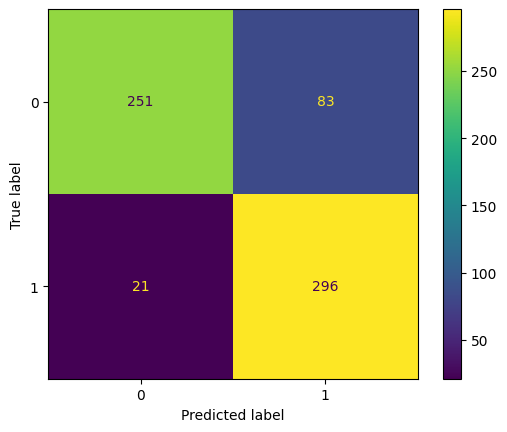

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display=ConfusionMatrixDisplay(cm)
display.plot()
plt.show()

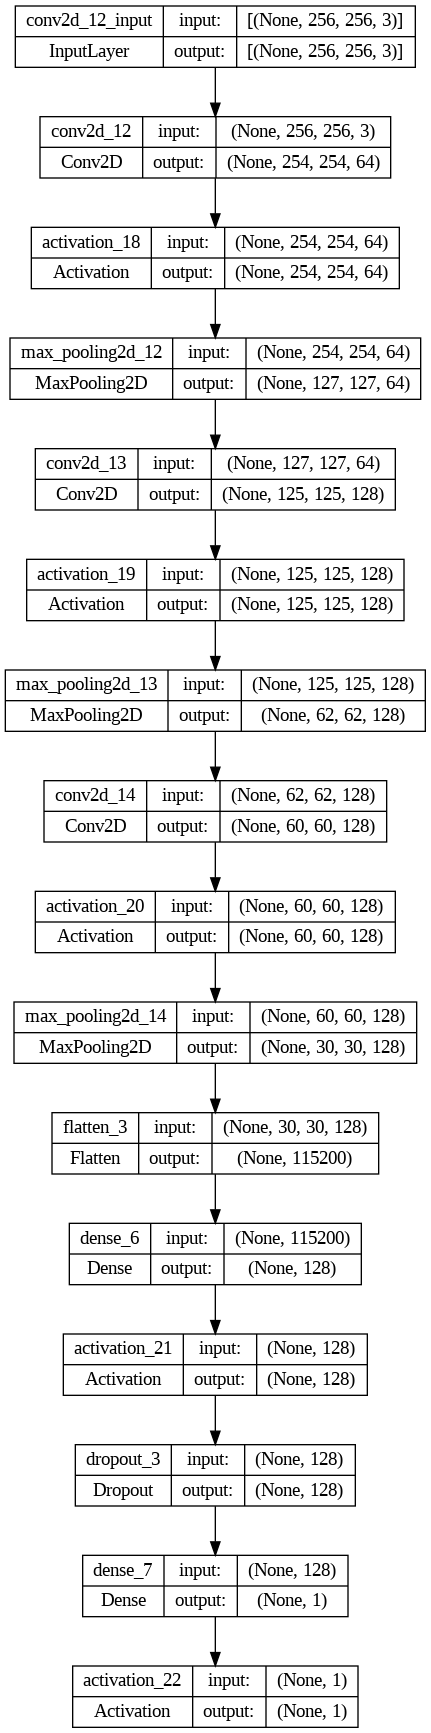

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          expand_nested=True)

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()
    except:
      pass

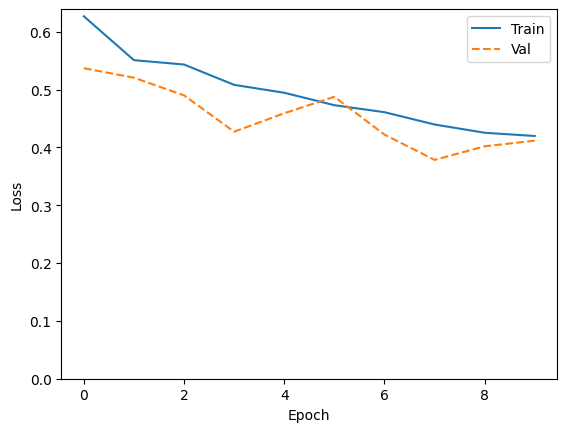

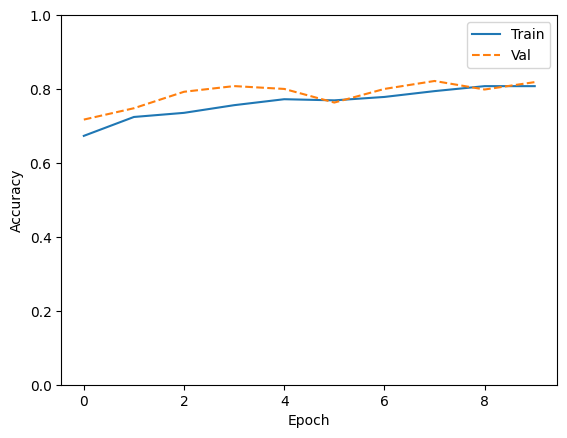

In [ ]:
plot_metrics(history)

1/1 [==============================] - 0s 108ms/step
[[1.]]
The uploaded X-ray image is: Tumor


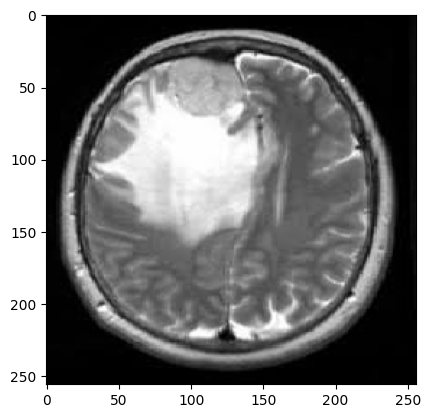

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

model = load_model('drive/MyDrive/Colab Notebooks/Tumor_CNN (1)/Tumor_CNN.h5')

img = load_img('drive/MyDrive/Colab Notebooks/Tumor_Efficientnet (1)/Tumor/pred/pred5.jpg',target_size=(256,256))

img_array  = img_to_array(img)
img_array = np.expand_dims(img_array,axis=0)
predictions = model.predict(img_array)
print(predictions)
if predictions[0] > 0.5:
    prediction_class = "Tumor"
else:
    prediction_class = "Healthy Brain"
plt.imshow(img)
print("The uploaded X-ray image is: " + prediction_class)